In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

import data_utils as HIVLoader
from elemBERT.model import ElemBERTModel

2024-05-11 08:50:44.894816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 08:50:45.386905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/daffaizzuddin/miniconda3/envs/interna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


## Load Datasets

In [2]:
df = pd.read_csv('elemBERT/HIVV1_ds.csv')
df['typesV1'] = df['typesV1'].apply(eval)
df.head()

,Unnamed: 0,typesV1,ids,formula,labels
0,0,"[C1, C5, C3, O0, Cu1, O0, C3, C5, C1, C5, O0, ...",0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,1,"[C3, C3, C0, C3, C3, C3, C3, C3, C3, O0, Cu1, ...",1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,2,"[C1, C3, O0, N1, C0, C3, C3, C3, C3, C0, S2, C...",2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,3,"[N3, C0, C3, C3, C0, C3, C3, C0, C3, C3, C0, N...",3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,4,"[O0, S6, O0, O2, C5, C5, S6, O0, O0, O2, H0, H...",4,O=S(=O)(O)CCS(=O)(=O)O,0


## Data Preparation

In [3]:
element2id = pickle.load(open('elemBERT/models/pretrained/el2idV1.pkl', 'rb'))['el2id']
vocab_size = len(element2id)
print('Element vocab size:', vocab_size)

Element vocab size: 565


In [4]:
add_special_token = lambda xs: ['[CLS]', *xs, '[SEP]']
tokenize_type = lambda xs: [element2id[x] for x in xs]
pad_sequence = lambda xs: tf.keras.preprocessing.sequence.pad_sequences([xs],
                                                                        dtype='int32',
                                                                        padding= 'post',
                                                                        truncating='post',
                                                                        maxlen=256)[0]

df['tokens']  = df['typesV1'].apply(add_special_token).apply(tokenize_type).apply(pad_sequence)
df.head()

,Unnamed: 0,typesV1,ids,formula,labels,tokens
0,0,"[C1, C5, C3, O0, Cu1, O0, C3, C5, C1, C5, O0, ...",0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0,"[3, 71, 75, 73, 308, 132, 308, 73, 75, 71, 75,..."
1,1,"[C3, C3, C0, C3, C3, C3, C3, C3, C3, O0, Cu1, ...",1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0,"[3, 73, 73, 70, 73, 73, 73, 73, 73, 73, 308, 1..."
2,2,"[C1, C3, O0, N1, C0, C3, C3, C3, C3, C0, S2, C...",2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0,"[3, 71, 73, 308, 267, 70, 73, 73, 73, 73, 70, ..."
3,3,"[N3, C0, C3, C3, C0, C3, C3, C0, C3, C3, C0, N...",3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0,"[3, 269, 70, 73, 73, 70, 73, 73, 70, 73, 73, 7..."
4,4,"[O0, S6, O0, O2, C5, C5, S6, O0, O0, O2, H0, H...",4,O=S(=O)(O)CCS(=O)(=O)O,0,"[3, 308, 422, 308, 310, 75, 75, 422, 308, 308,..."


In [5]:
train_ds, val_ds, test_ds = HIVLoader.scaffold_split(df, x_col='tokens', y_col='labels', id_col='formula')

print(f'total: {len(train_ds):5d}, active: {sum(train_ds.y):4d}, inactive: {sum(train_ds.y == False):5d}')
print(f'total: {len(val_ds):5d}, active: {sum(val_ds.y):4d}, inactive: {sum(val_ds.y == False):5d}')
print(f'total: {len(test_ds):5d}, active: {sum(test_ds.y):4d}, inactive: {sum(test_ds.y == False):5d}')

[08:50:56] WARNING: not removing hydrogen atom without neighbors
[08:50:56] WARNING: not removing hydrogen atom without neighbors


total: 28774, active: 1090, inactive: 27684
total:  8221, active:  219, inactive:  8002
total:  4111, active:  130, inactive:  3981


## Model

In [6]:
class Config:
  MAX_LEN = 256
  BATCH_SIZE = 32
  LR = 0.0001
  VOCAB_SIZE = vocab_size
  EMBED_DIM = 128
  NUM_HEAD = 4 # used in bert model
  FF_DIM = 32 # used in bert model
  NUM_LAYERS = 2
  MNAME = 'elembert_'
  MVER = 'V1'
  
config = Config()
model = ElemBERTModel(Config, out=2, out_act='softmax')

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

2024-05-11 08:50:57.745610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 08:50:57.745846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 08:50:57.746640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ types (InputLayer)  │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ element_embdgs      │ (None, 256, 128)  │     72,320 │ types[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 128)  │          0 │ element_embdgs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__multihe… │ (None, 256, 128)  │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__att_dro… │ (None, 256, 128)  │          0 │ encoder_0__multi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ encoder_0__att_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__att_lay… │ (None, 256, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__ffn      │ (None, 256, 128)  │      8,352 │ encoder_0__att_l… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__ffn_dro… │ (None, 256, 128)  │          0 │ encoder_0__ffn[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 128)  │          0 │ encoder_0__att_l… │
│                     │                   │            │ encoder_0__ffn_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__ffn_lay… │ (None, 256, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__multihe… │ (None, 256, 128)  │     66,048 │ encoder_0__ffn_l… │
│ (MultiHeadAttentio… │                   │            │ encoder_0__ffn_l… │
│                     │                   │            │ encoder_0__ffn_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__att_dro… │ (None, 256, 128)  │          0 │ encoder_1__multi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 128)  │          0 │ encoder_0__ffn_l… │
│                     │                   │            │ encoder_1__att_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__att_lay… │ (None, 256, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__ffn      │ (None, 256, 128)  │      8,352 │ encoder_1__att_l… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__ffn_dro… │ (None, 256, 128)  │          0 │ encoder_1__ffn[0

 Total params: 222,402 (868.76 KB)

 Trainable params: 222,402 (868.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def convert_ds(ds):
  X = np.array([*ds.X])
  y = tf.one_hot(ds.y, 2)
  return X, y

X_train, y_train = convert_ds(train_ds)
X_val, y_val = convert_ds(val_ds)
X_test, y_test = convert_ds(test_ds)

In [8]:
class TestCallback(tf.keras.callbacks.Callback):
  def __init__(self, test_dataset):
    super().__init__()
    self.test_dataset = test_dataset

  def on_epoch_end(self, epoch, logs=None):
    X, ylog = self.test_dataset
    y = np.argmax(ylog, axis=1)
    
    logits = self.model.predict(X)
    preds = np.argmax(logits, axis=1)
    
    roc_auc = roc_auc_score(ylog, logits)
    f1 = f1_score(y, preds)
    recall = recall_score(y, preds)
    acc = accuracy_score(y, preds)
    
    logs['val_roc_auc'] = roc_auc
    logs['val_f1'] = f1
    logs['val_recall'] = recall
    logs['val_acc'] = acc

In [9]:
best_auc_path = os.path.join('checkpoints', 'elemBERT', 'best_roc_auc_score', 'checkpoint.keras')
best_f1_path = os.path.join('checkpoints', 'elemBERT', 'best_f1_score', 'checkpoint.keras')
best_recall_path = os.path.join('checkpoints', 'elemBERT', 'best_recall_score', 'checkpoint.keras')

In [10]:
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_val, y_val),
                    verbose=1, epochs=128, batch_size=64,
                    callbacks=[
                      TestCallback((X_val, y_val)),
                      tf.keras.callbacks.ModelCheckpoint(best_auc_path, monitor='val_roc_auc', save_best_only=True, mode='max', verbose=1),
                      tf.keras.callbacks.ModelCheckpoint(best_f1_path, monitor='val_f1', save_best_only=True, mode='max', verbose=1),
                      tf.keras.callbacks.ModelCheckpoint(best_recall_path, monitor='val_recall', save_best_only=True, mode='max', verbose=1)
                    ])

Epoch 1/128


I0000 00:00:1715417461.106920 3591832 service.cc:145] XLA service 0x7f8850006ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715417461.106940 3591832 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1715417461.106942 3591832 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-11 08:51:01.173090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 08:51:01.486194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-05-11 08:51:02.920111: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compi

 13/450 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5312

I0000 00:00:1715417473.320824 3591832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1935

I0000 00:00:1715417481.930498 3592136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_90', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715417483.631799 3592135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_55', 412 bytes spill stores, 416 bytes spill loads

I0000 00:00:1715417484.057579 3592131 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_83', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715417484.073363 3592130 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_86', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715417485.919920 3592132 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_83', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715417486.476052 3592131 asm_comp

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1934

I0000 00:00:1715417493.437405 3592397 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_18', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715417494.491943 3592401 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715417497.109576 3592496 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads



257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Epoch 1: val_roc_auc improved from -inf to 0.63621, saving model to checkpoints/elemBERT/best_roc_auc_score/checkpoint.keras

Epoch 1: val_f1 improved from -inf to 0.00000, saving model to checkpoints/elemBERT/best_f1_score/checkpoint.keras

Epoch 1: val_recall improved from -inf to 0.00000, saving model to checkpoints/elemBERT/best_recall_score/checkpoint.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.1934 - val_loss: 0.1213 - val_roc_auc: 0.6362 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.9734
Epoch 2/128
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 2: val_roc_auc improved from 0.63621 to 0.63766, saving model to checkpoints/elemBERT/best_roc_auc_score/checkpoint.keras

Epoch 2: val_f1 did not improve from 0.00000

Epoch 2: val_recall did not improve from 0.00000
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1622 - val_loss: 0.1194 - val_roc_auc: 0.6377 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00 - val_ac

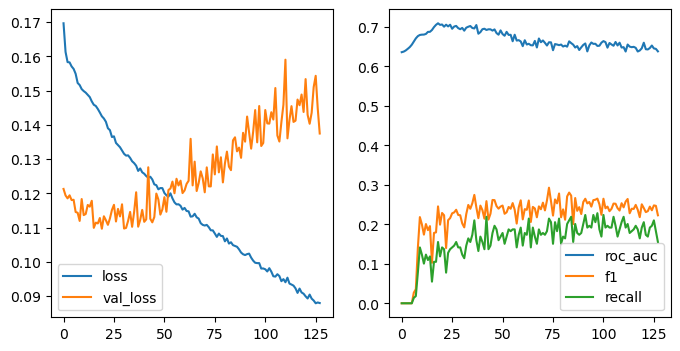

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(history.history['val_roc_auc'])
axs[1].plot(history.history['val_f1'])
axs[1].plot(history.history['val_recall'])
axs[1].legend(['roc_auc', 'f1', 'recall'])

plt.show()

## Evaluation

In [12]:
def eval_model(model, X_test, y_test):
  model.load_weights(best_auc_path)
  logits = model.predict(X_test)
  preds = np.argmax(logits, axis=1)
  y = np.argmax(y_test, axis=1)
  
  roc_auc = roc_auc_score(y_test, logits)
  f1 = f1_score(y, preds)
  recall = recall_score(y, preds)
  acc = accuracy_score(y, preds)

  print('roc-auc:', roc_auc)
  print('f1:', f1)
  print('accuracy:', acc)
  print('recall:', recall)

  cm = confusion_matrix(test_ds.y, preds, normalize='true')
  disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm)

  cm = confusion_matrix(test_ds.y, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  disp_norm.plot(ax=axs[0])
  disp.plot(ax=axs[1])
  plt.tight_layout() 
  plt.plot()

### Evaluate model on last epoch

110/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1715418428.742436 3597271 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads



129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
roc-auc: 0.7781428129770256
f1: 0.25609756097560976
accuracy: 0.9703235222573583
recall: 0.16153846153846155


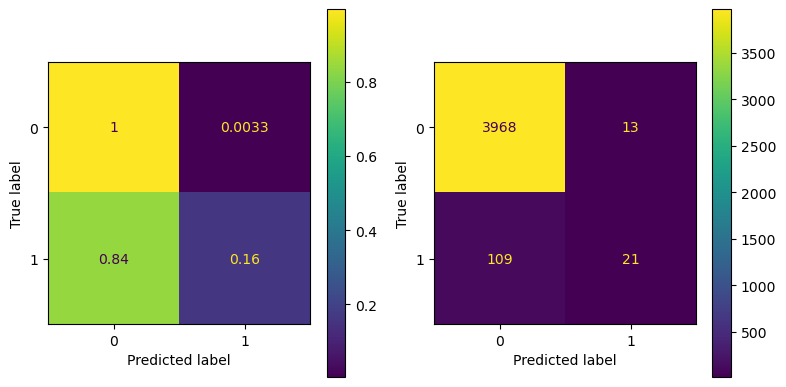

In [13]:
eval_model(model, X_test, y_test)

### Evaluate model with best AUC score

In [14]:
tf.keras.config.enable_unsafe_deserialization()

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
roc-auc: 0.7781428129770256
f1: 0.25609756097560976
accuracy: 0.9703235222573583
recall: 0.16153846153846155


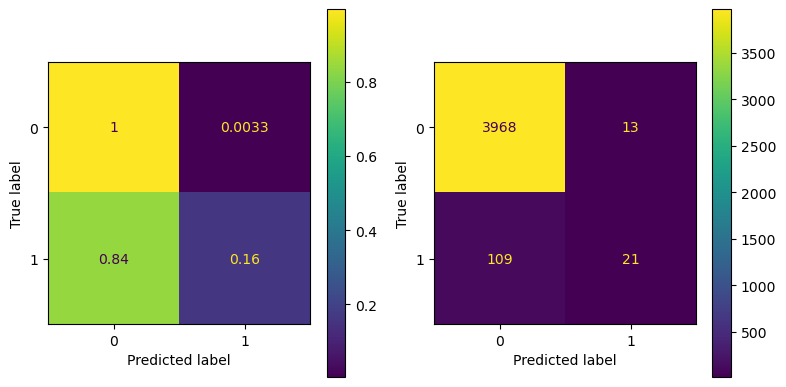

In [15]:
auc_model = tf.keras.models.load_model(best_auc_path)
eval_model(auc_model, X_test, y_test)

### Test on model with best F1 score

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
roc-auc: 0.7781428129770256
f1: 0.25609756097560976
accuracy: 0.9703235222573583
recall: 0.16153846153846155


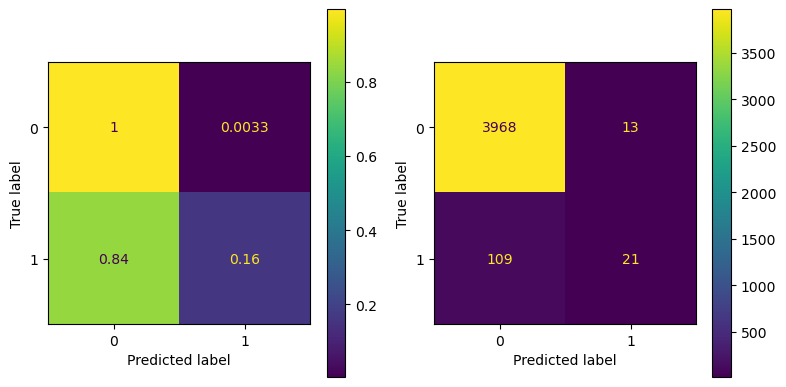

In [16]:
f1_model = tf.keras.models.load_model(best_f1_path)
eval_model(f1_model, X_test, y_test)

### Evaluate model with best recall score

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
roc-auc: 0.7781428129770256
f1: 0.25609756097560976
accuracy: 0.9703235222573583
recall: 0.16153846153846155


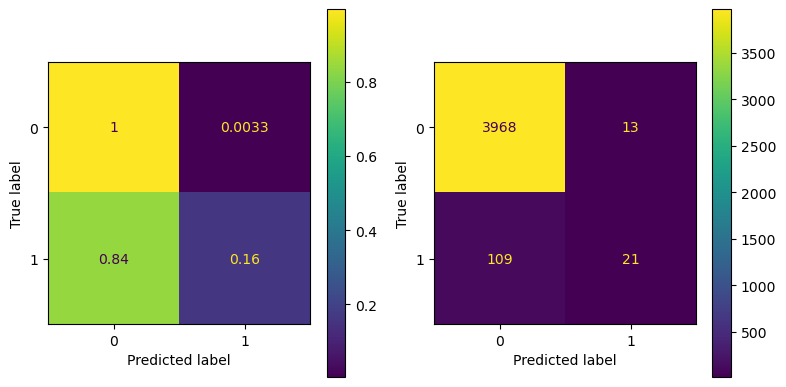

In [17]:
recall_model = tf.keras.models.load_model(best_recall_path)
eval_model(recall_model, X_test, y_test)